# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [3]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)


    label, statement = data_line[1], data_line[2]

    return (label, statement)


In [4]:
import re
# Input: a string of one statement
def pre_process(text):

    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    text = text.lower()

    tokens = text.split()

    char_ngrams = [text[i:i + 3] for i in range(len(text) - 2)]

    # Include trigrams
    trigrams = [tokens[i] + "_" + tokens[i + 1] + "_" + tokens[i + 2] for i in range(len(tokens) - 2)]

    # Include bigrams
    bigrams = [tokens[i] + "_" + tokens[i + 1] for i in range(len(tokens) - 1)]

    #Stylistic features
    sentences = text.split('.')
    sentence_lengths = [len(sentence) for sentence in sentences]
    #return sentence_lengths



    return tokens + bigrams + trigrams + char_ngrams + sentence_lengths




    #return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [5]:
global_feature_dict = {} # A global dictionary of features
i=0

def to_feature_vector(tokens, training="True"):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    featureVector = {}  # local feature vector for this example (in dict form)
    for t in tokens:

        # First add to the global feature dictionary, and give it a position
        # if in training
        try:
            # if the word t is in the dictionary,
            # then assign i to its value in the dictionary
            i = global_feature_dict[t]
        except KeyError:
            # else if it's not in the dictionary,
            # it's a new feature in training, add new entry
            if training:
                i = len(global_feature_dict) + 1
                global_feature_dict[t] = i
            else:
                # At test time don't add new entry
                i = global_feature_dict["<unk/>",None]  # get the special unknown word token

        # Add to local feature vector (as a dictionary entry with a weight)

        # Skip over None values
        if i is None:
            continue
        try:
            # if the word w is in the local feature vector (repeat word), add 1/n weight
            featureVector[i] += 1 #(1.0/len(words))
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[i] = 1 #(1.0/len(words))

        if False:
            # example binary alternative to the above (just add it as 1 if present)
            if not i in featureVector.keys():
                featureVector[i] = 1


    return featureVector


In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual=True, max_iter=5000))])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [7]:
#solution
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1


    # Initialize variables to store cumulative metrics
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_accuracy = 0

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        train_set = dataset[:i] + dataset[i + fold_size:]
        test_set = dataset[i:i + fold_size]

        # Train the classifier using train_set
        classifier = train_classifier(train_set)

        # Predict labels for the test_set
        predicted_labels = predict_labels([x[0] for x in test_set], classifier)

        # Get ground-truth labels
        true_labels = [x[1] for x in test_set]


        # Calculate metrics for the current fold
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary', pos_label="positive")
        accuracy = accuracy_score(true_labels, predicted_labels)

        # Accumulate metrics for averaging later
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        total_accuracy += accuracy

    # Calculate average metrics across all folds
    avg_precision = total_precision / folds
    avg_recall = total_recall / folds
    avg_f1 = total_f1 / folds
    avg_accuracy = total_accuracy / folds



    cv_results = {
        'Average Precision': avg_precision,
        'Average Recall': avg_recall,
        'Average F1 Score': avg_f1,
        'Average Accuracy': avg_accuracy
    }
    # Return the average metrics for further analysis if needed
    return cv_results




In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [9]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')




Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
966980


In [10]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...


{'Average Precision': 0.8813962341618959,
 'Average Recall': 0.9056330705302769,
 'Average F1 Score': 0.8932641583348335,
 'Average Accuracy': 0.8603920926533586}

# Question 4: Error Analysis (20 marks)

Training Classifier...


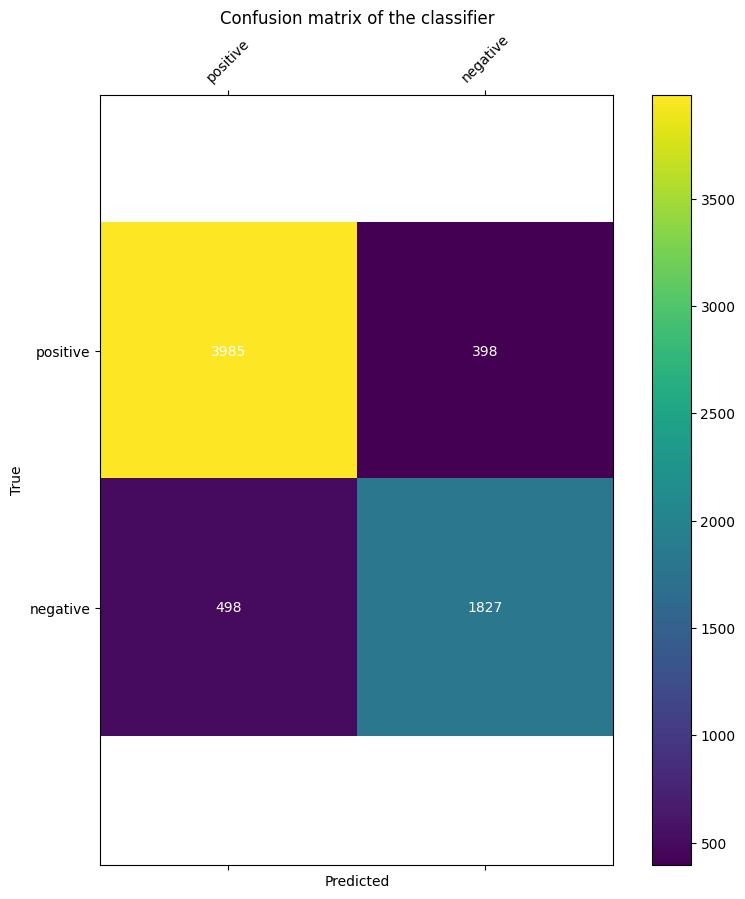

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

# Assuming test_data is a list of tuples (features, label)
# where 'label' is the true label and 'features' is the feature vector
test_features = [features for features, label in test_data]
true_labels = [label for features, label in test_data]

# Assuming you have a trained classifier stored in the 'classifier' variable
classifier = train_classifier(train_data)
predicted_labels = predict_labels(test_features, classifier)

# Now you can call the confusion_matrix_heatmap function
confusion_matrix_heatmap(true_labels, predicted_labels, labels=["positive", "negative"])


In [12]:
false_positives = [(test_features[i], true_labels[i]) for i in range(len(test_data))
                   if predicted_labels[i] == "positive" and true_labels[i] == "negative"]

false_negatives = [(test_features[i], true_labels[i]) for i in range(len(test_data))
                   if predicted_labels[i] == "negative" and true_labels[i] == "positive"]

# Print or write to file
with open("false_positives.txt", "w") as f:
    for features, true_label in false_negatives:
        f.write(f"True Label: {true_label}\n")
        f.write(f"Features:{features}\n\n")

with open("false_positives.txt", "w") as f:
    for features, true_label in false_negatives:
        f.write(f"True Label: {true_label}\n")
        f.write(f"Features:{features}\n\n")

#print("FALSE NEGATIVES", false_negatives)
#print("FALSE POSITIVES", false_positives)


# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [13]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({764: 1, 1832: 2, 5: 2, 6114: 2, 8581: 1, 430: 4, 390561: 1, 755: 1, 429: 1, 804578: 1, 804579: 1, 2297: 1, 1903: 2, 804580: 1, 769: 2, 1388: 1, 1124: 1, 236270: 1, 111: 2, 23404: 1, 11446: 1, 3278: 2, 6133: 2, 804581: 1, 264886: 1, 804582: 1, 804583: 1, 773: 1, 804584: 1, 804585: 1, 804586: 1, 8000: 1, 8001: 1, 804587: 1, 804588: 1, 3277: 1, 244208: 1, 43766: 1, 325953: 1, 804589: 1, 232660: 1, 684604: 1, 52021: 1, 46314: 2, 804590: 1, 804591: 1, 804592: 1, 804593: 1, 804594: 1, 804595: 1, 804596: 1, 804597: 1, 804598: 1, 8016: 1, 804599: 1, 804600: 1, 804601: 1, 3305: 1, 244225: 1, 244226: 1, 804602: 1, 804603: 1, 804604: 1, 804605: 1, 855: 1, 856: 1, 857: 1, 693: 1, 858: 1, 859: 1, 176: 1, 4326: 1, 1889: 2, 1890: 2, 538: 2, 61: 2, 6182: 2, 6183: 2, 715: 2, 1345: 1, 1692: 1, 4766: 1, 1163: 1, 549: 1, 2459: 1, 4767: 1, 3681: 1, 527: 2, 531: 2, 532: 2, 3262: 1, 103453: 1, 390585: 1, 10240: 1, 83: 1, 12170: 1, 820: 1, 821: 1, 822: 1, 823: 1, 824: 1, 825: 1, 826: 1, 528: 1, 529: 1, 2232